#Lab 2 Inteligencia de Negocios [ICI6442]

Autores:
- Andrés Vidal
- Valentina San Martín

Contenidos:
1. Descripción del Dataset
2. Importación de liberías y del dataset
3. Preprocesamiento de Datos
4. Exploración de Datos
5. Análisis de Patrones con K-Means
6. Interpretación de Resultados

#1. Descripción del Dataset

Para el siguiente Laboratorio se escogió un dataset de Our World In Data distinto al usado en el Laboratorio 1 para poder graficar más fácilmente las variables, al ser las de este dataset de tipo cuantitativo. Este dataset muestra la relación entre la esperanza de vida promedio (Average Life Expectancy) y la cantidad de años que se espera que una persona viva con una pérdida de salud (enfermedad o discapacidad) ya sea a corto o a largo plazo (Expected years lived with disability or disease). Este dataset incluye además de las variables mencionadas previamente, el año de cada registro (entre 1990 y 2016), el país, el continente, población (estimado histórico) y un código del país.

Este laboratorio busca encontrar una tendencia entre la esperanza de vida promedio (Average Life Expectancy) y la cantidad de años que se espera que una persona viva con una enfermedad o discapacidad y compararlo con los continentes para evaluar la posible relación entre estos. Para esto se utilizará el algoritmo de clusterización K-Means.


#2. Importación de librerías y del dataset

In [32]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from mlxtend.preprocessing import TransactionEncoder

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
chunksize = 10000
data = pd.DataFrame()
for chunk in pd.read_csv('life-expectancy-vs-expected-years-lived-with-disability.csv', chunksize=chunksize):
    data = pd.concat([data, chunk], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#3. Preprocesamiento de Datos

El preprocesamiento de datos cuenta con diferentes transformaciones, las cuales son utilizadas para tener un conjunto de datos mejor descrito.

Estas transformaciones son:

* Cambiar los valores NaN: Los valores NaN tanto de variables string como
 de variables numéricas, son modificadas por "no especificado" y por un promedio de toda la columna, respectivamente.
* Eliminar filas con datos faltantes: Se eliminan filas que no posean las columnas 'Years lived with disability' y 'Life Expectancy (IHME)' ya que no serán utilizadas para el análisis
* Escalar los datos: Finalmente se escalan los datos para que la varianza sea menor y así al graficar sea más representativo.

In [34]:
# Separar columnas numéricas y no numéricas
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64']).columns

# Imputar valores faltantes en columnas numéricas con la media
imputer_num = SimpleImputer(strategy='mean')
data_numeric = pd.DataFrame(imputer_num.fit_transform(data[numeric_cols]), columns=numeric_cols)

# Imputar valores faltantes en columnas no numéricas con "no especificado"
data_non_numeric = data[non_numeric_cols].fillna('no especificado')

# Combinar nuevamente el conjunto de datos
data_imputed = pd.concat([data_numeric, data_non_numeric], axis=1)

processed_data = data.dropna(subset=["Years lived with disability", "Life Expectancy (IHME)"])

X = data_imputed[['Years lived with disability', 'Life Expectancy (IHME)']]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#4. Exploración de Datos

In [35]:
# Exploración de la base de datos
print(data_imputed.head())
print(data_imputed.info())
print(data_imputed.describe())

     Year  Life Expectancy (IHME)  Years lived with disability  \
0  2015.0               68.746711                     8.828415   
1  1990.0               51.600000                     8.030000   
2  1991.0               51.280000                     7.910000   
3  1992.0               51.400000                     7.900000   
4  1993.0               51.340000                     7.850000   

   Population (historical estimates)       Entity      Code        Continent  
0                       4.901082e+07     Abkhazia  OWID_ABK             Asia  
1                       1.069480e+07  Afghanistan       AFG  no especificado  
2                       1.074517e+07  Afghanistan       AFG  no especificado  
3                       1.205744e+07  Afghanistan       AFG  no especificado  
4                       1.400376e+07  Afghanistan       AFG  no especificado  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59110 entries, 0 to 59109
Data columns (total 7 columns):
 #   Column          

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


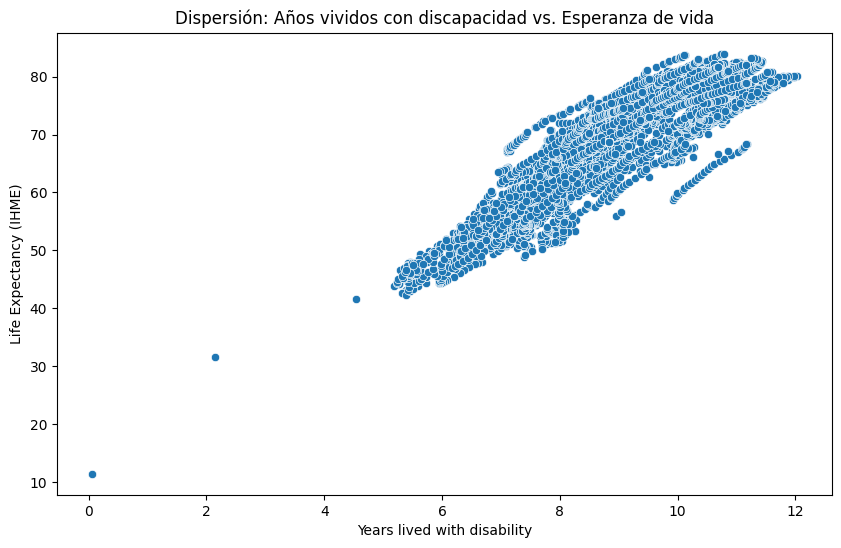

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Years lived with disability', y='Life Expectancy (IHME)', data=data_imputed)
plt.title('Dispersión: Años vividos con discapacidad vs. Esperanza de vida')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


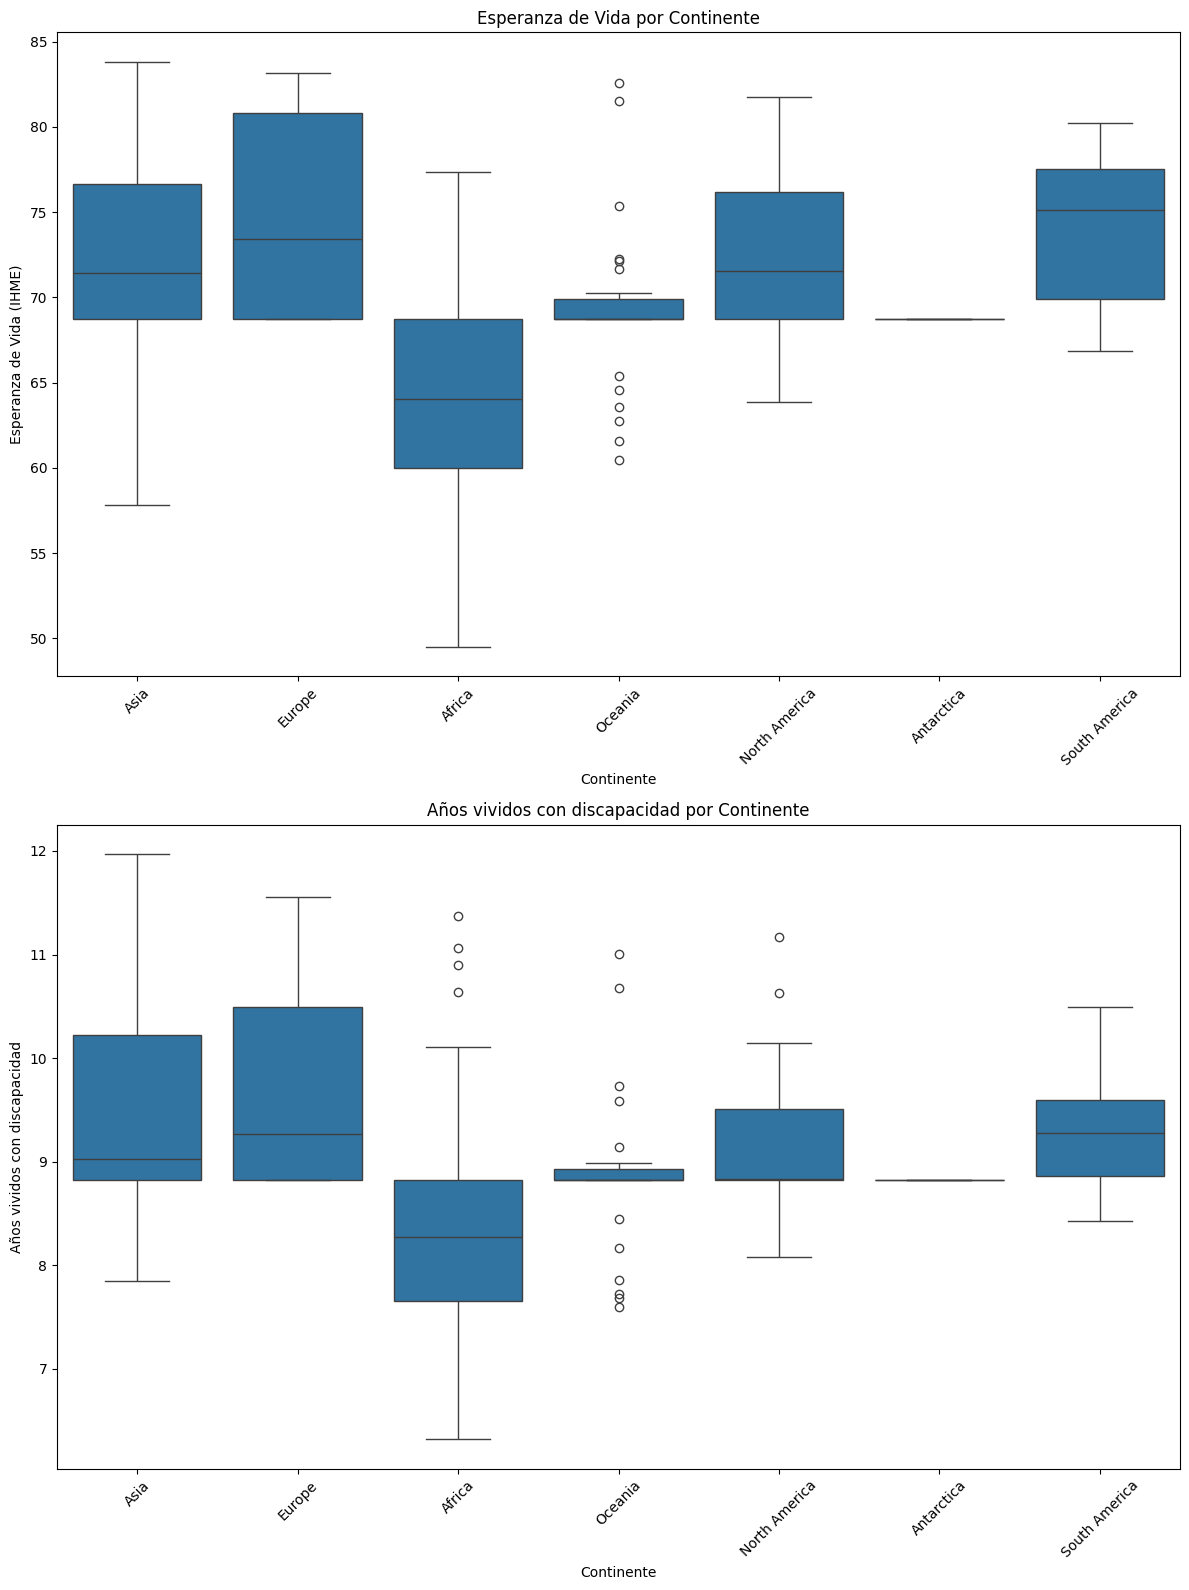

In [37]:
# Filtrar datos donde el continente no sea "no especificado"
data_filtered = data_imputed[data_imputed["Continent"] != "no especificado"]

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Histograma de Esperanza de Vida por Continente
sns.boxplot(x='Continent', y='Life Expectancy (IHME)', data=data_filtered, ax=ax1)
ax1.set_title('Esperanza de Vida por Continente')
ax1.set_xlabel('Continente')
ax1.set_ylabel('Esperanza de Vida (IHME)')
ax1.tick_params(axis='x', rotation=45)

# Histograma de Años vividos con discapacidad por Continente
sns.boxplot(x='Continent', y='Years lived with disability', data=data_filtered, ax=ax2)
ax2.set_title('Años vividos con discapacidad por Continente')
ax2.set_xlabel('Continente')
ax2.set_ylabel('Años vividos con discapacidad')
ax2.tick_params(axis='x', rotation=45)

# Ajustar el layout
plt.tight_layout()
plt.show()

#5. Análisis de Patrones con K-Means

Una vez visualizadas las instancias dentro del gráfico, para determinar el número de clústers a utilizar en el algoritmo K-Means con la regla del codo, donde se graficará la inercia por cada número de clusters K y el número de K que de las coordenadas más cercanas al (0,0) corresponde al número óptimo de K.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Gráfico de Inercia vs K para K-Means:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

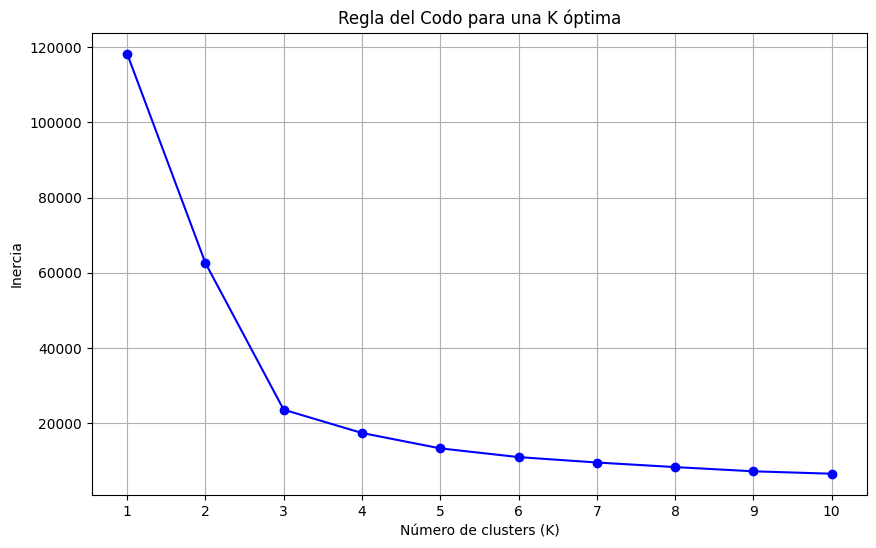

In [38]:
# Gráfico de Inercia vs clusters (K) para el algoritmo K-Means
print("\nGráfico de Inercia vs K para K-Means:")
inertias = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'bo-')
plt.title('Regla del Codo para una K óptima')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

En este caso el número óptimo de clusters es K = 3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


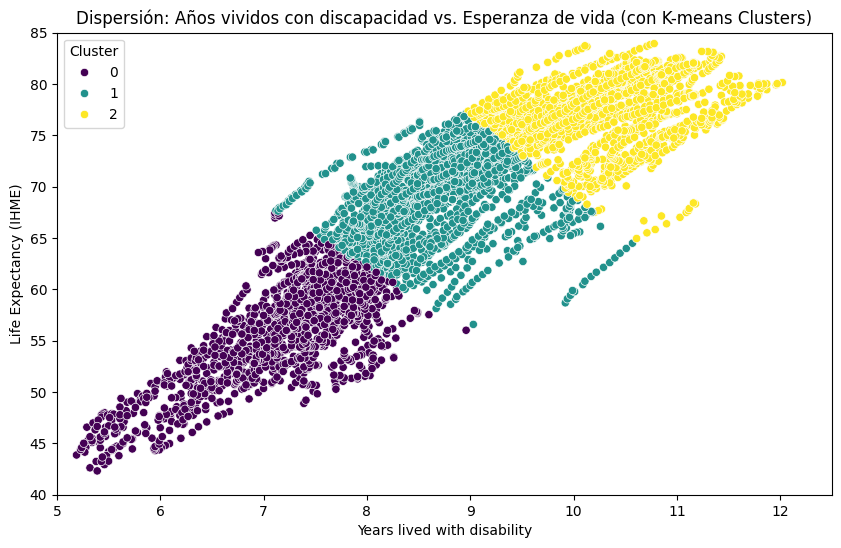

Inertia: 23643.006723921295
Silhouette Score: 0.93518818678577
Calinski-Harabasz Score: 118220.20792126188


In [39]:
# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Añadir los resultados de la clusterización a los datos originales
data_imputed['Cluster'] = kmeans.labels_

# Visualizar los clusters en el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Years lived with disability', y='Life Expectancy (IHME)', hue='Cluster', palette='viridis', data=data_imputed)
plt.title('Dispersión: Años vividos con discapacidad vs. Esperanza de vida (con K-means Clusters)')
plt.xlim(5, 12.5)
plt.ylim(40, 85)
plt.show()

print("Inertia:", kmeans.inertia_)

from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

from sklearn.metrics import calinski_harabasz_score
calinski_score = calinski_harabasz_score(X_scaled, kmeans.labels_)
print("Calinski-Harabasz Score:", calinski_score)

#6. Interpretación de Resultados

Como se puede ver en el siguiente gráfico, existe una tendencia donde los países de África pertenecen en su mayoría al cluster 0, los países americanos (Norteamérica y Sudamérica) al cluster 1, los países de Europa al cluster 2. Mientras que Asia se encuentra entre los clusters 1 y 2 y Oceanía se encuentra disperso entre los 3 clusters.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


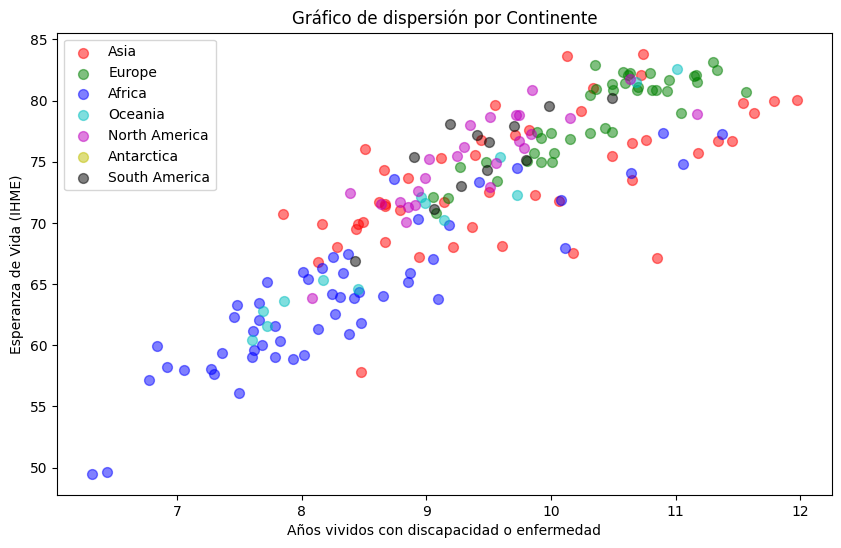

In [40]:
# Filtrar los datos donde el continente no sea "no especificado"
data_filtered = data[data["Continent"] != "no especificado"]

# Definir colores por continente
continents = data_filtered["Continent"].dropna().unique()
colors = ["r", "g", "b", "c", "m", "y", "k"]

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
for continent, color in zip(continents, colors):
    continent_data = data_filtered[data_filtered["Continent"] == continent]
    plt.scatter(continent_data["Years lived with disability"], continent_data["Life Expectancy (IHME)"],
                color=color, label=continent, s=50, alpha=0.5)

plt.title("Gráfico de dispersión por Continente")
plt.xlabel('Años vividos con discapacidad o enfermedad')
plt.ylabel('Esperanza de Vida (IHME)')
plt.legend()
plt.show()